# Assignment 2

## Instructions
- Your submission should be the `.ipynb` file with your name,
  like `YusufMesbah.ipynb`. it should include the answers to the questions in
  markdown cells.
- You are expected to follow the best practices for code writing and model
training. Poor coding style will be penalized.
- You are allowed to discuss ideas with your peers, but no sharing of code.
Plagiarism in the code will result in failing. If you use code from the
internet, cite it.
- If the instructions seem vague, use common sense.

# Task 1: ANN (30%)
For this task, you are required to build a fully connect feed-forward ANN model
for a multi-label regression problem.

For the given data, you need do proper data preprocessing, design the ANN model,
then fine-tune your model architecture (number of layers, number of neurons,
activation function, learning rate, momentum, regularization).

For evaluating your model, do $80/20$ train test split.

### Data
You will be working with the data in `Task 1.csv` for predicting students'
scores in 3 different exams: math, reading and writing. The columns include:
 - gender
 - race
 - parental level of education
 - lunch meal plan at school
 - whether the student undertook the test preparation course

### Imports and Inits

In [1]:
import time
import copy

import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder

import matplotlib.pyplot as plt

In [2]:
class CustomGradesDataset(Dataset):
  """
  Dataset for the grades data
  NOTE: grades are divided by 100 to make them in the range [0, 1]
  """
  def __init__(self, X, y):
    self.X = torch.from_numpy(X)
    self.y = torch.from_numpy(y)

  def __len__(self):
      return len(self.X)

  def __getitem__(self, i):
      return self.X[i].float(), self.y[i].float() / 100

In [3]:
class ANNModel(nn.Module):
    """
    Custom ANNModel for grades prediction
    """
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(ANNModel, self).__init__()
        self.input_dim = input_dim
        self.layers = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 3 * hidden_dim),
            nn.ReLU(),
            nn.Linear(3 * hidden_dim, 2 * hidden_dim),
            nn.ReLU(),
            nn.Linear(2 * hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )
    
    def forward(self, x):
        if len(x.shape) > 2:
            x = x.view(-1, self.input_dim)
        out = self.layers(x.float())
        return out

### Data loading and preprocessing

In [ ]:
dataset = pd.read_csv("Task 1.csv")

X = dataset.iloc[:, :-3]
y = dataset.iloc[:, -3:]

display(X.head())
display(y.head())

,gender,race/ethnicity,parental level of education,lunch,test preparation course
0,male,group A,high school,standard,completed
1,female,group D,some high school,free/reduced,none
2,male,group E,some college,free/reduced,none
3,male,group B,high school,standard,none
4,male,group E,associate's degree,standard,completed


,math score,reading score,writing score
0,67,67,63
1,40,59,55
2,59,60,50
3,77,78,68
4,78,73,68


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# We will ordinally encode every column
X_column_transformer = ColumnTransformer([
    ('ordinal', OrdinalEncoder(), X_train.keys()),
])
X_column_transformer.fit(X_train)

X_train = pd.DataFrame(X_column_transformer.transform(X_train), columns=dataset.keys()[:-3])
X_test = pd.DataFrame(X_column_transformer.transform(X_test), columns=dataset.keys()[:-3])

In [ ]:
train_batch_size = 32
test_batch_size = 8

# While imput and output dims are obvious
# we will use the number of hidden neurons
# as a hyperparameter to tune
# currently my model has 3 hidden layers
# with linear combination of 200 neurons
input_dim = X_train.shape[1]
hidden_dim = 200
output_dim = y_train.shape[1]

In [ ]:
traindataset = CustomGradesDataset(X_train.to_numpy(dtype='float64'), y_train.to_numpy(dtype='float64'))
testdataset = CustomGradesDataset(X_test.to_numpy(dtype='float64'), y_test.to_numpy(dtype='float64'))

trainloader = DataLoader(traindataset, batch_size=train_batch_size, shuffle=True, num_workers=0)
testloader = DataLoader(testdataset, batch_size=test_batch_size, shuffle=False, num_workers=0)

### Model training and evaluation

In [ ]:
def fit_predict(model, trainloader, testloader, device):
    """
    A function to train a given model on the trainloader
    and evaluate it on the testloader.

    :param model: model to train
    :param trainloader: trainloader to train on
    :param testloader: testloader to evaluate on
    :param device: device to train on

    :return: result dictionary with best
    model weights, train and test mse history,
    batchwise as well as epochwise.
    """
    
    epochs = 40
    lr = 0.0001
    momentum = 0.5

    criterion = MSELoss()
    optimizer = optim.NAdam(model.parameters(), lr=lr, momentum_decay=0.05)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.3, patience=3, verbose=True)

    since = time.time()

    result = {
        'best_model_wts': copy.deepcopy(model.state_dict()),
        'best_loss': 1000.0,
        'train_mse_history': [],
        'test_mse_history': [],
        'train_mse_history_b': [],
        'test_mse_history_b': [],
    }

    for epoch in range(1, epochs + 1):
        print(f'Epoch {epoch}/{epochs}')
        print('-' * 10)

        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()
                dataloader = trainloader
            else:
                model.eval()
                dataloader = testloader
            
            running_loss = 0.0

            for inputs, labels in dataloader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                
                running_loss += loss.item() * inputs.size(0)
                result[f'{phase}_mse_history_b'] += [loss.item() * inputs.size(0)]

            if phase == 'train':
                scheduler.step(loss)

            epoch_loss = running_loss / len(dataloader.dataset)
            
            result[f'{phase}_mse_history'] += [epoch_loss]

            if epoch_loss < result['best_loss']:
                result['best_loss'] = epoch_loss
                result['best_model_wts'] = copy.deepcopy(model.state_dict())
            
            print(f'{phase} Loss=MSE: {epoch_loss:.4f}')
    print('Time: {:.0f}m {:.0f}s'.format((time.time() - since) // 60, (time.time() - since) % 60))
    return result

In [ ]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

model = ANNModel(input_dim, hidden_dim, output_dim).to(device)

print(f'Device: {device}')
print(model)

Device: cpu
ANNModel(
  (layers): Sequential(
    (0): Linear(in_features=5, out_features=200, bias=True)
    (1): ReLU()
    (2): Linear(in_features=200, out_features=600, bias=True)
    (3): ReLU()
    (4): Linear(in_features=600, out_features=400, bias=True)
    (5): ReLU()
    (6): Linear(in_features=400, out_features=200, bias=True)
    (7): ReLU()
    (8): Linear(in_features=200, out_features=3, bias=True)
  )
)


In [ ]:
result = fit_predict(model, trainloader, testloader, device)
best_model_wts = result['best_model_wts']
torch.save(best_model_wts, 'best_ann_wts.pt')

Epoch 1/40
----------
train Loss=MSE: 0.1861
test Loss=MSE: 0.0590
Epoch 2/40
----------
train Loss=MSE: 0.0414
test Loss=MSE: 0.0344
Epoch 3/40
----------
train Loss=MSE: 0.0259
test Loss=MSE: 0.0250
Epoch 4/40
----------
train Loss=MSE: 0.0214
test Loss=MSE: 0.0216
Epoch 5/40
----------
train Loss=MSE: 0.0197
test Loss=MSE: 0.0198
Epoch 6/40
----------
train Loss=MSE: 0.0185
test Loss=MSE: 0.0205
Epoch 7/40
----------
train Loss=MSE: 0.0178
test Loss=MSE: 0.0187
Epoch 8/40
----------
train Loss=MSE: 0.0179
test Loss=MSE: 0.0188
Epoch 9/40
----------
Epoch 00009: reducing learning rate of group 0 to 3.0000e-05.
train Loss=MSE: 0.0171
test Loss=MSE: 0.0178
Epoch 10/40
----------
train Loss=MSE: 0.0166
test Loss=MSE: 0.0179
Epoch 11/40
----------
train Loss=MSE: 0.0165
test Loss=MSE: 0.0177
Epoch 12/40
----------
train Loss=MSE: 0.0165
test Loss=MSE: 0.0177
Epoch 13/40
----------
train Loss=MSE: 0.0165
test Loss=MSE: 0.0176
Epoch 14/40
----------
Epoch 00014: reducing learning rate of g

### Results analysis

In [ ]:
model.load_state_dict(best_model_wts)

<All keys matched successfully>

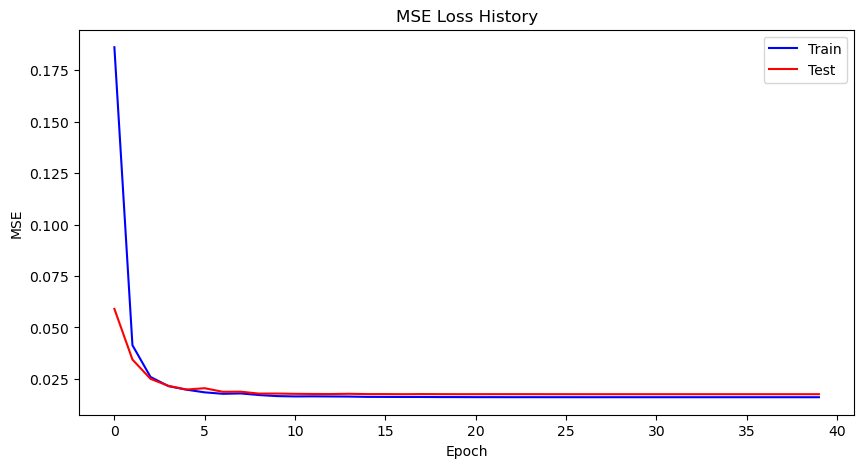

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.set_title('MSE Loss History')
ax.plot(result['train_mse_history'], color='blue', label='Train')
ax.plot(result['test_mse_history'], color='red', label='Test')
ax.set_xlabel('Epoch')
ax.set_ylabel('MSE')
ax.legend()
plt.show()

We can see that basically there was no point in training after 10-15th epoch, as the model was not improving. However we can do so, since our model is training fast and we are separately saving the best performing weights.

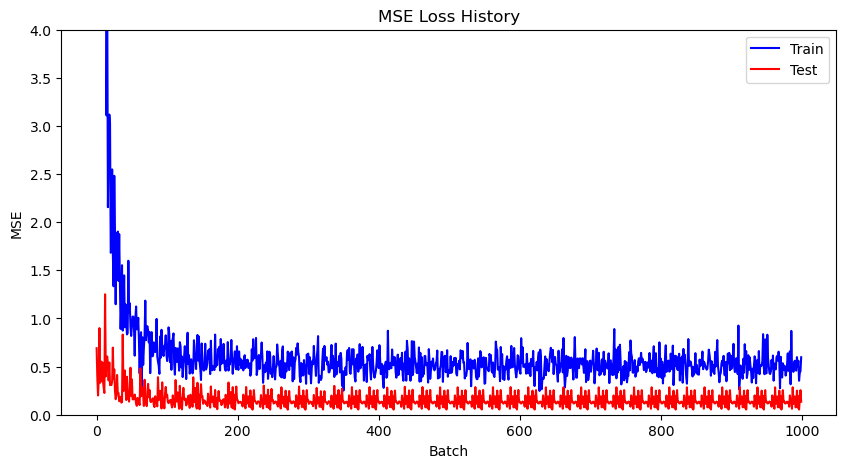

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.set_title('MSE Loss History')
ax.set_ylim((0, 4))
ax.plot(result['train_mse_history_b'], color='blue', label='Train')
ax.plot(result['test_mse_history_b'], color='red', label='Test')
ax.set_xlabel('Batch')
ax.set_ylabel('MSE')
ax.legend()
plt.show()

However we have to consider that above is only mean MSE on the epoch, while batchwise MSE is much less stable, while producing the same mean. Even though we still can see that the pattern is repeating, so there is no need in so many epochs of training.

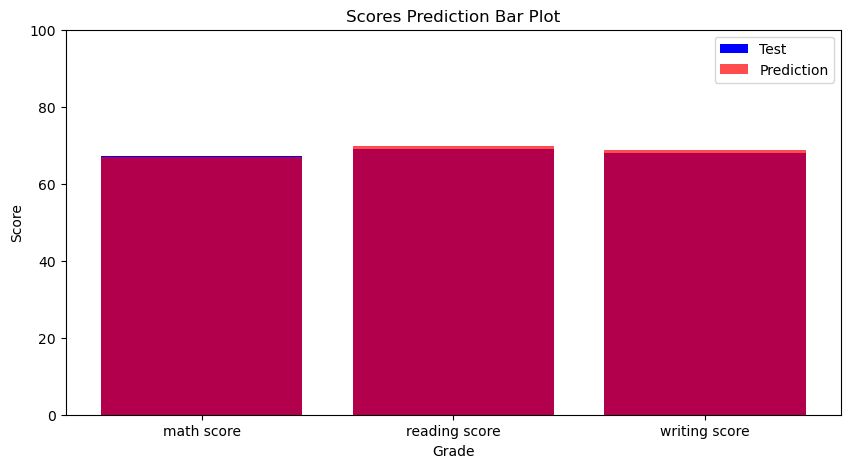

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))

predictloader = DataLoader(testdataset, batch_size=len(testdataset), shuffle=False)
inputs, labels = next(iter(predictloader))
preds = (model(inputs.to(device)).detach().cpu().numpy() * 100).mean(axis=0)

ax.set_title('Scores Prediction Bar Plot')
ax.set_ylim((0, 100))

ax.bar(y_test.keys(), y_test.mean().to_numpy(), color='blue', label='Test', alpha=1)
ax.bar(y_test.keys(), (model(inputs).detach().numpy() * 100).mean(axis=0), color='red', label='Prediction', alpha=0.7)
ax.set_xlabel('Grade')
ax.set_ylabel('Score')
ax.legend()
plt.show()

We can see, that our best model shows great results in predicting mean score. Results are so close to each other, that they are almost indistinghuishable for each exam. This result implies that even though our scores predictions are not ideal, they are still very close to the real scores and simply oscillate around them.

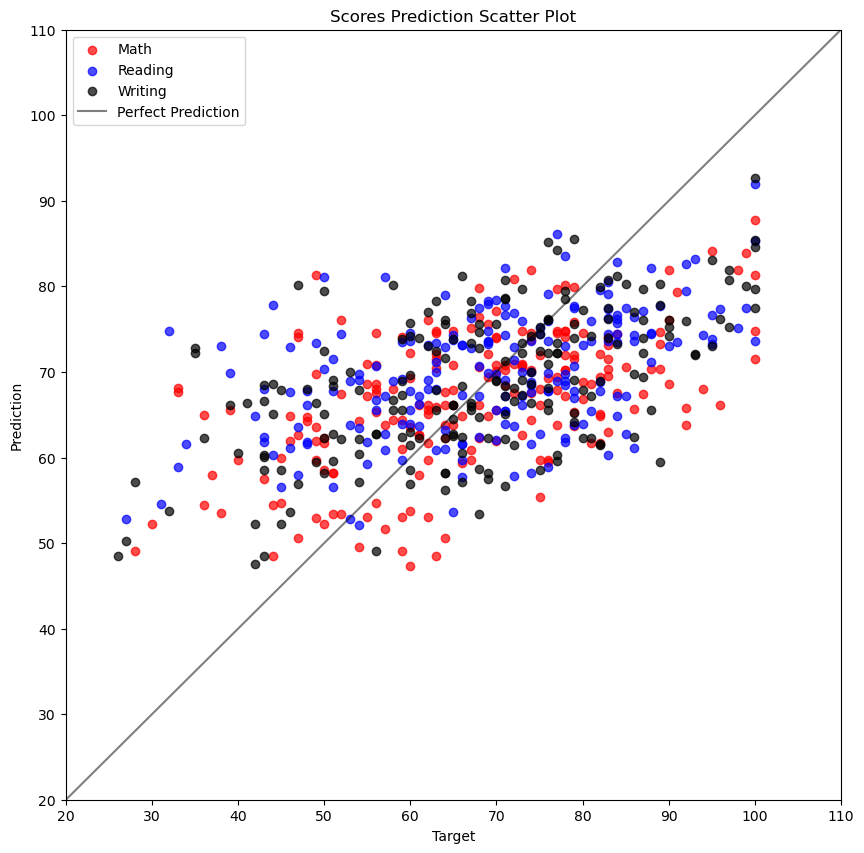

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))

ax.set_title('Scores Prediction Scatter Plot')
ax.set_ylim((20, 110))
ax.set_xlim((20, 110))

ax.scatter(y_test['math score'], (model(inputs).detach().numpy() * 100)[:, 0], color='red', label='Math', alpha=0.7)
ax.scatter(y_test['reading score'], (model(inputs).detach().numpy() * 100)[:, 1], color='blue', label='Reading', alpha=0.7)
ax.scatter(y_test['writing score'], (model(inputs).detach().numpy() * 100)[:, 2], color='black', label='Writing', alpha=0.7)
ax.plot([0, 110], [0, 110], color='black', label='Perfect Prediction', alpha=0.5)
ax.set_xlabel('Target')
ax.set_ylabel('Prediction')
ax.legend()
plt.show()

Here is another representation of the results. The bisecting line is the perfect prediction, while points are separate individual predictions for each of the test samples. The distance to the bisecting line is the error of the prediction. As we can see, our model struggles to predict very low and very high scores, while it is very good at predicting scores in the middle, as they are close to the mean. 

I suppose that very low and very high scores are simply outliers for our model (which is generally true) and it is not able to predict them well. However, it is still able to predict the mean score very well, which is the most important thing for us.

### Questions
1. What preprocessing techniques did you use? Why?
    - Since all the data in categorical format, we have to adapt it to the model. We can use either OrdinalEncoder or OneHotEncoder. Firstly it may seem reasonable to use one-hot encoder, since usually categorical data does not have an ordinal relationship. However, in this task we are predicting test scores, and it is reasonable to assume that the higher the level of education, the higher the score. I tried several combinations of encoders and came up with using `OrdinalEncoder` on all the columns. While it may seem unreasonable, it greatly improves model computational performance, since number of features to consider is greatly reduced and it did not impact the model accuracy, as we can see on the graphs above. Therefore the preprocessing is as follows:
      - `OrdinalEncoder` on all the columns
      - Scale the output scores to the range of $[0, 1]$ (simply divide by 100)
    - To get a score after prediction, we have to simply multiple it by 100.
2. Describe the fine-tuning process and how you reached your model architecture.
    - *Answer*

# Task 2: CNN (40%)
For this task, you will be doing image classification:
- First, adapt your best model from Task 1 to work on this task, and
fit it on the new data. Then, evaluate its performance.
- After that, build a CNN model for image classification.
- Compare both models in terms of accuracy, number of parameters and speed of
inference (the time the model takes to predict 50 samples).

For the given data, you need to do proper data preprocessing and augmentation,
data loaders.
Then fine-tune your model architecture (number of layers, number of filters,
activation function, learning rate, momentum, regularization).

### Data
You will be working with the data in `triple_mnist.zip` for predicting 3-digit
numbers writen in the image. Each image contains 3 digits similar to the
following example (whose label is `039`):

![example](https://github.com/shaohua0116/MultiDigitMNIST/blob/master/asset/examples/039/0_039.png?raw=true)

## Imports and Inits

In [4]:
import time
import copy

from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, models, transforms
from torch.optim import lr_scheduler
import torch.nn.functional as F
import torch.optim as optim
import torch.nn as nn
import torch

import numpy as np
import matplotlib.pyplot as plt

In [ ]:
def ml_split(num):
    """
    Multiple Hot Encoding of the
    given number into 30 bits.
    Each 10 bits for one digit
    """
    res = [0] * 30
    res[int(num[0])] = 1
    res[int(num[1]) + 10] = 1
    res[int(num[2]) + 20] = 1
    return res

In [ ]:
def hot_to_ind(tens):
    """
    Convert a 30 bits vector
    into a 3 digits number
    """
    _, preds = torch.max(tens[0].view(-1, 10), dim=1)
    for i in range(1, len(tens)):
        _, pred1 = torch.max(tens[i].view(-1, 10), dim=1)
        preds = torch.cat((preds, pred1))
    preds = preds.view(-1, 3)
    return preds

In [7]:
class CNNModel(nn.Module):
    """
    Pretty basic convoltional neural network
    """
    def __init__(self):
        super(CNNModel, self).__init__()
        self.ConvLayer1 = nn.Sequential(
            nn.Conv2d(1, 64, 3), 
            nn.MaxPool2d(2), 
            nn.ReLU(), 
        )
        self.ConvLayer2 = nn.Sequential(
            nn.Conv2d(64, 128, 3), 
            nn.MaxPool2d(2),
            nn.ReLU()
        )
        self.ConvLayer3 = nn.Sequential(
            nn.Conv2d(128, 256, 3),
            nn.MaxPool2d(2),
            nn.ReLU()
        )
        self.ConvLayer4 = nn.Sequential(
            nn.Conv2d(256, 512, 3),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Dropout(0.2)
        )
        self.dense = nn.Sequential(
            nn.Linear(512 * 3 * 3, 1024),
            nn.Linear(1024, 512),
            nn.Linear(512, 256),
            nn.Linear(256, 30)
        )
        self.act = nn.Sigmoid()
    def forward(self, x):
        x = self.ConvLayer1(x)
        x = self.ConvLayer2(x)
        x = self.ConvLayer3(x)
        x = self.ConvLayer4(x)
        x = x.view(x.size(0), -1)
        x = self.dense(x)
        return self.act(x)

## Preprocessing and Data Augmentation

In [8]:
chan_num = 1
angle = 15

# Preprocessing should be separate
# transformation same for all the
# datasets of the task
preprocessing = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, ), (0.5,)),
    transforms.Grayscale(chan_num)
])

# Augmentations however, should be
# unique for each dataset
# Even though I did not add them 
# in this iteration of the solution
train_transform = transforms.Compose([
    preprocessing
])
test_transform = transforms.Compose([
    preprocessing
])
val_transform = transforms.Compose([
    preprocessing
])

train_dataset = datasets.ImageFolder(root='triple_mnist/train', transform=train_transform)
val_dataset = datasets.ImageFolder(root='triple_mnist/val', transform=val_transform)
test_dataset = datasets.ImageFolder(root='triple_mnist/test', transform=train_transform)

In [9]:
batch_size = 128

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) # Shuffle train
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)    # Do not shuffle validation
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)  # Do not shuffle test

dataloaders = {'train': train_loader, 'val': val_loader, 'test': test_loader}
dataset_sizes = {'train': len(train_dataset), 'val': len(val_dataset), 'test': len(test_dataset)}
image_datasets = {'train': train_dataset, 'val': val_dataset, 'test': test_dataset}

## Models training and evaluation

In [51]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25, activate=False):
    """
    Function to train the given model on the 
    triple_mnist dataset with train and validation phases

    :param model: The model to train
    :param criterion: The loss function
    :param optimizer: The optimizer
    :param scheduler: The scheduler
    :param num_epochs: The number of epochs to train
    :param activate: Whether to activate the outputs

    :return: result: Dictionary with deep history of
    the training and the best model weights
    """
    since = time.time()

    """
    Deep history of the training
    """
    result = {
        'train_loss': [],
        'val_loss': [],
        'train_acc': [],
        'val_acc': [],
        'train_dt': [],
        'val_dt': [],
        'best_model_wts': copy.deepcopy(model.state_dict()),
        'best_acc': 0.0
    }

    # These recorders used for accurate
    # inference time calculation
    starter, ender = torch.cuda.Event(enable_timing=True), torch.cuda.Event(enable_timing=True)

    for epoch in range(1, num_epochs + 1):
        print(f'Epoch {epoch}/{num_epochs}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_total_corrects = 0
            running_any_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):

                    # We should consider both model 
                    # inference and activation
                    # when considering inference time
                    starter.record()
                    outputs = model(inputs)
                    if activate:
                      outputs = torch.sigmoid(outputs)
                    ender.record()

                    torch.cuda.synchronize()
                    cur_time = starter.elapsed_time(ender)
                    result[f'{phase}_dt'] += [cur_time]

                    preds = hot_to_ind(outputs)
                    target = torch.from_numpy(np.array([ml_split(image_datasets[phase].classes[label]) for label in labels])).to(device)
                    target = target.type(torch.FloatTensor).to(device)
                    loss = criterion(outputs, target)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                    

                ind_target = hot_to_ind(target)
                running_loss += loss.item() * inputs.size(0)
                running_any_corrects += torch.sum(preds == ind_target)
                for i in range(len(ind_target)):
                    # Whole number should be predicted
                    running_total_corrects += torch.equal(preds[i], ind_target[i])
                  
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_total_acc = float(running_total_corrects) / dataset_sizes[phase]
            epoch_any_acc = running_any_corrects.double() / (3 * dataset_sizes[phase])

            result[f'{phase}_loss'] += [epoch_loss]
            result[f'{phase}_acc'] += [(epoch_total_acc, epoch_any_acc)]

            print(f'{phase} \nLoss: {epoch_loss:.4f} Any Acc: {epoch_any_acc:.4f} Total Acc: {epoch_total_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_total_acc > result['best_acc']:
                result['best_acc'] = epoch_total_acc
                result['best_model_wts'] = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {result["best_acc"]:4f}')

    return result

In [ ]:
def test_model(model, phase, activate=False):
    """
    Function to test the given model on the
    dataset with the given phase

    :param model: The model to test
    :param phase: The phase to test on
    :param activate: Whether to activate the outputs

    :return: result: Dictionary with the test results
    """

    model.eval()

    since = time.time()

    result = {
        'loss': [],
        'acc': [],
        'dt': []
    }

    # These recorders used for accurate
    # inference time calculation
    starter, ender = torch.cuda.Event(enable_timing=True), torch.cuda.Event(enable_timing=True)
    with torch.no_grad():

        running_loss = 0.0
        running_any_corrects = 0
        running_total_corrects = 0

        for inputs, labels in dataloaders[phase]:
            inputs = inputs.to(device)
            labels = labels.to(device)

            # We should consider both model 
            # inference and activation
            # when considering inference time
            starter.record()
            outputs = model(inputs)
            if activate:
                outputs = torch.sigmoid(outputs)
            ender.record()

            torch.cuda.synchronize()
            cur_time = starter.elapsed_time(ender)
            result['dt'] += [cur_time]

            preds = hot_to_ind(outputs)
            target = torch.from_numpy(np.array([ml_split(image_datasets[phase].classes[label]) for label in labels])).to(device)
            target = target.type(torch.FloatTensor).to(device)

            loss = F.binary_cross_entropy(outputs, target)

            ind_target = hot_to_ind(target)

            running_loss += loss.item() * inputs.size(0)
            running_any_corrects += torch.sum(preds == ind_target)
            for i in range(len(ind_target)):
                running_total_corrects += torch.equal(preds[i], ind_target[i])

        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_total_acc = float(running_total_corrects) / dataset_sizes[phase]
        epoch_any_acc = running_any_corrects.double() / (3 * dataset_sizes[phase])

        result[f'loss'] += [epoch_loss]
        result[f'acc'] += [(epoch_total_acc, epoch_any_acc.clone().cpu().numpy())]

        print(f'{phase}: \nLoss: {epoch_loss} Any Acc: {epoch_any_acc:.4f} Total Acc: {epoch_total_acc:.4f}')

        return result

In [62]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

model_ann = ANNModel(1 * 84 * 84, 200, 30).to(device)
model_cnn = CNNModel().to(device)

criterion = nn.BCELoss()

optimizer_ann = optim.NAdam(model_ann.parameters(), lr=0.001, momentum_decay=0.5)
exp_lr_scheduler_ann = lr_scheduler.StepLR(optimizer_ann, step_size=7, gamma=0.1)

optimizer_cnn = optim.NAdam(model_cnn.parameters(), lr=0.001, momentum_decay=0.5)
exp_lr_scheduler_cnn = lr_scheduler.StepLR(optimizer_cnn, step_size=7, gamma=0.1)

display(model_ann)
display(model_cnn)

ANNModel(
  (layers): Sequential(
    (0): Linear(in_features=7056, out_features=200, bias=True)
    (1): ReLU()
    (2): Linear(in_features=200, out_features=600, bias=True)
    (3): ReLU()
    (4): Linear(in_features=600, out_features=400, bias=True)
    (5): ReLU()
    (6): Linear(in_features=400, out_features=200, bias=True)
    (7): ReLU()
    (8): Linear(in_features=200, out_features=30, bias=True)
  )
)

CNNModel(
  (ConvLayer1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
  )
  (ConvLayer2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
  )
  (ConvLayer3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
  )
  (ConvLayer4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
  )
  (dense): Sequential(
    (0): Linear(in_features=4608, out_features=1024, bias=True)
    (1): Linear(in_features=1024, out_features=512, bias=True)
    (2): Linear(in_features=512, 

### ANN

In [54]:
train_result = train_model(model_ann, criterion, optimizer_ann, exp_lr_scheduler_ann, num_epochs=7, activate=True)

Epoch 1/7
----------
train 
Loss: 0.3157 Any Acc: 0.1729 Total Acc: 0.0073
val 
Loss: 0.2934 Any Acc: 0.2561 Total Acc: 0.0159

Epoch 2/7
----------
train 
Loss: 0.2764 Any Acc: 0.3101 Total Acc: 0.0311
val 
Loss: 0.2689 Any Acc: 0.3284 Total Acc: 0.0316

Epoch 3/7
----------
train 
Loss: 0.2597 Any Acc: 0.3637 Total Acc: 0.0517
val 
Loss: 0.2662 Any Acc: 0.3332 Total Acc: 0.0249

Epoch 4/7
----------
train 
Loss: 0.2515 Any Acc: 0.3886 Total Acc: 0.0623
val 
Loss: 0.2551 Any Acc: 0.3647 Total Acc: 0.0372

Epoch 5/7
----------
train 
Loss: 0.2454 Any Acc: 0.4071 Total Acc: 0.0705
val 
Loss: 0.2524 Any Acc: 0.3789 Total Acc: 0.0423

Epoch 6/7
----------
train 
Loss: 0.2403 Any Acc: 0.4235 Total Acc: 0.0803
val 
Loss: 0.2537 Any Acc: 0.3700 Total Acc: 0.0348

Epoch 7/7
----------
train 
Loss: 0.2366 Any Acc: 0.4331 Total Acc: 0.0850
val 
Loss: 0.2441 Any Acc: 0.4036 Total Acc: 0.0488

Training complete in 6m 13s
Best val Acc: 0.048750


In [57]:
model_ann.load_state_dict(train_result['best_model_wts'])
torch.save(train_result['best_model_wts'], 'best_ann_2_wts.pt')
test_result = test_model(model_ann, 'test', activate=True)

test: 
Loss: 0.24538787565231324 Any Acc: 0.4057 Total Acc: 0.0488


In [58]:
ann_result = [train_result, test_result]

### CNN

In [63]:
train_result = train_model(model_cnn, criterion, optimizer_cnn, exp_lr_scheduler_cnn, num_epochs=7)

Epoch 1/7
----------
train 
Loss: 0.3035 Any Acc: 0.2251 Total Acc: 0.0348
val 
Loss: 0.1472 Any Acc: 0.7105 Total Acc: 0.3263

Epoch 2/7
----------
train 
Loss: 0.0469 Any Acc: 0.9366 Total Acc: 0.8323
val 
Loss: 0.0151 Any Acc: 0.9833 Total Acc: 0.9509

Epoch 3/7
----------
train 
Loss: 0.0114 Any Acc: 0.9884 Total Acc: 0.9654
val 
Loss: 0.0083 Any Acc: 0.9906 Total Acc: 0.9721

Epoch 4/7
----------
train 
Loss: 0.0077 Any Acc: 0.9929 Total Acc: 0.9787
val 
Loss: 0.0078 Any Acc: 0.9922 Total Acc: 0.9767

Epoch 5/7
----------
train 
Loss: 0.0066 Any Acc: 0.9947 Total Acc: 0.9840
val 
Loss: 0.0076 Any Acc: 0.9921 Total Acc: 0.9766

Epoch 6/7
----------
train 
Loss: 0.0058 Any Acc: 0.9957 Total Acc: 0.9871
val 
Loss: 0.0074 Any Acc: 0.9932 Total Acc: 0.9797

Epoch 7/7
----------
train 
Loss: 0.0056 Any Acc: 0.9960 Total Acc: 0.9880
val 
Loss: 0.0081 Any Acc: 0.9928 Total Acc: 0.9784

Training complete in 9m 7s
Best val Acc: 0.979688


In [64]:
torch.save(train_result['best_model_wts'], 'best_cnn_wts.pt')
model_cnn.load_state_dict(train_result['best_model_wts'])
test_result = test_model(model_cnn, 'test')

test: 
Loss: 0.007421313685644418 Any Acc: 0.9929 Total Acc: 0.9788


In [65]:
cnn_result = [train_result, test_result]

## Results Analysis

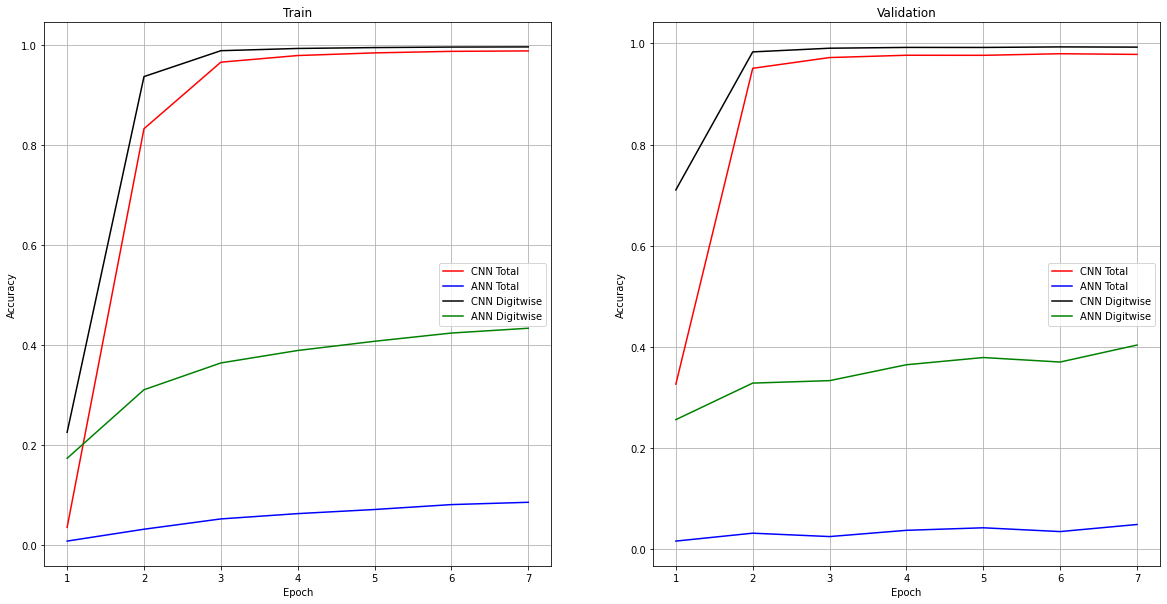

In [92]:
ann_train_acc = ann_result[0]['train_acc']
cnn_train_acc = cnn_result[0]['train_acc']

ann_val_acc = ann_result[0]['val_acc']
cnn_val_acc = cnn_result[0]['val_acc']

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(20, 10))

ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.set_title('Train')

ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('Validation')

ax1.plot(range(1, 8), [acc[0] for acc in cnn_train_acc], color='red', label='CNN Total')
ax1.plot(range(1, 8), [acc[0] for acc in ann_train_acc], color='blue', label='ANN Total')

ax1.plot(range(1, 8), [acc[1].cpu() for acc in cnn_train_acc], color='black', label='CNN Digitwise')
ax1.plot(range(1, 8), [acc[1].cpu() for acc in ann_train_acc], color='green', label='ANN Digitwise')

ax2.plot(range(1, 8), [acc[0] for acc in cnn_val_acc], color='red', label='CNN Total')
ax2.plot(range(1, 8), [acc[0] for acc in ann_val_acc], color='blue', label='ANN Total')

ax2.plot(range(1, 8), [acc[1].cpu() for acc in cnn_val_acc], color='black', label='CNN Digitwise')
ax2.plot(range(1, 8), [acc[1].cpu() for acc in ann_val_acc], color='green', label='ANN Digitwise')

for ax in [ax1, ax2]:
  ax.legend()
  ax.grid()

plt.show()

As we can see, our CNN model is much more accurate than ANN. While ANN was able to successfully predict approximately 40% of digits, it was unable to predict even 10% of whole numbers. Even though ANN was still improving, it was not able to catch up with CNN in adequate time.

Moreover, CNN does not need so much epochs to find a working hypothesis for predictions. These graphs show that CNN has incredibly faster convergence as well as it is so well suited for image recognition tasks.

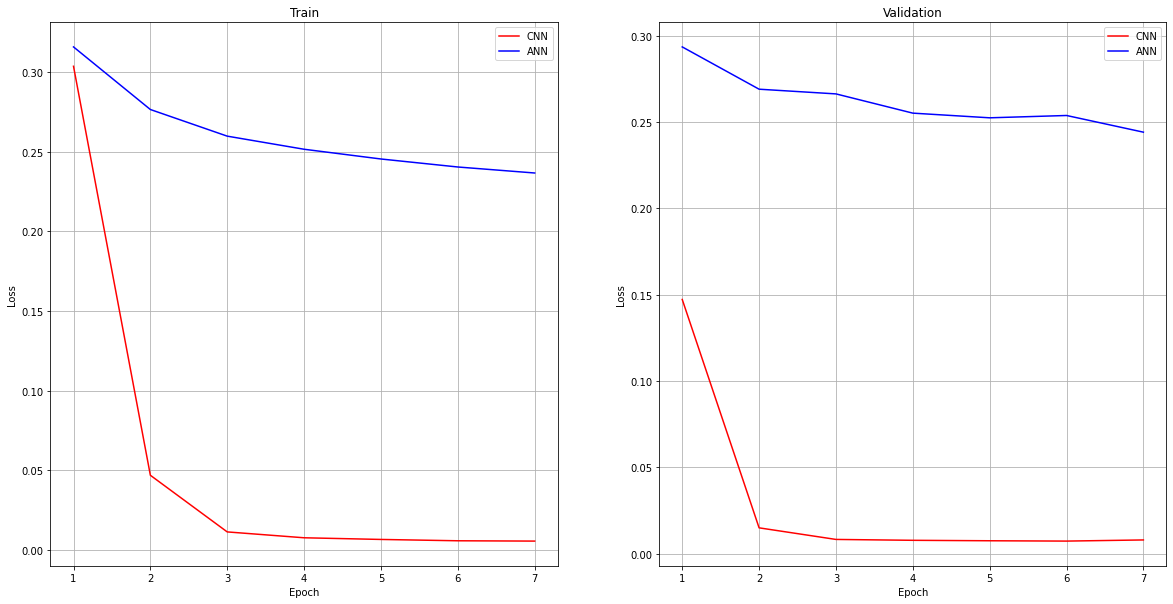

In [98]:
ann_train_loss = ann_result[0]['train_loss']
cnn_train_loss = cnn_result[0]['train_loss']

ann_val_loss = ann_result[0]['val_loss']
cnn_val_loss = cnn_result[0]['val_loss']

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(20, 10))

ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Train')

ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.set_title('Validation')

ax1.plot(range(1, 8), cnn_train_loss, color='red', label='CNN')
ax1.plot(range(1, 8), ann_train_loss, color='blue', label='ANN')

ax2.plot(range(1, 8), cnn_val_loss, color='red', label='CNN')
ax2.plot(range(1, 8), ann_val_loss, color='blue', label='ANN')

for ax in [ax1, ax2]:
  ax.legend()
  ax.grid()

plt.show()

Loss graphs simply prove everything said above about the accuracy. CNN converges to the great result starting from 4th epoch, while ANN is still far from the good result. Moreover, CNN is able to predict the whole number, while ANN is still struggling to predict the digits.

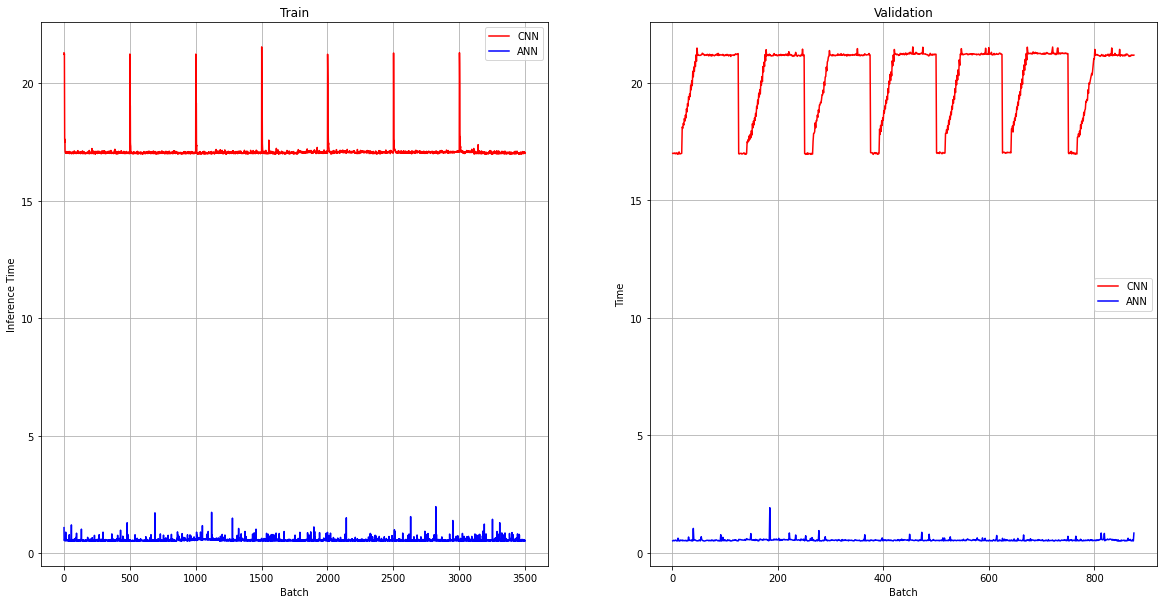

In [100]:
ann_train_dt = ann_result[0]['train_dt']
cnn_train_dt = cnn_result[0]['train_dt']

ann_val_dt = ann_result[0]['val_dt']
cnn_val_dt = cnn_result[0]['val_dt']

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(20, 10))

ax1.set_xlabel('Batch')
ax1.set_ylabel('Inference Time')
ax1.set_title('Train')

ax2.set_xlabel('Batch')
ax2.set_ylabel('Time')
ax2.set_title('Validation')

ax1.plot(range(1, 3501), cnn_train_dt, color='red', label='CNN')
ax1.plot(range(1, 3501), ann_train_dt, color='blue', label='ANN')

ax2.plot(range(1, 876), cnn_val_dt, color='red', label='CNN')
ax2.plot(range(1, 876), ann_val_dt, color='blue', label='ANN')

for ax in [ax1, ax2]:
  ax.legend()
  ax.grid()

plt.show()

However, as we can see, inference time of the CNN model is much higher than the ANN model. This is due to the fact that CNN model is much more complex and has much more parameters to consider. However, it is still much faster than the ANN model, which is not surprising, since ANN is a very simple model.

In [110]:
model_ann.load_state_dict(ann_result[0]['best_model_wts'])
model_cnn.load_state_dict(cnn_result[0]['best_model_wts'])

ann_total_params = sum(p.numel() for p in model_ann.parameters())
cnn_total_params = sum(p.numel() for p in model_cnn.parameters())

print(f'ANN: {ann_total_params}, CNN: {cnn_total_params}')

ANN: 1858630, CNN: 6933278


It is an obvious reason of the performance difference between the models, and inference time of the models. CNN is much greater than ANN, but has 7 millions of parameters to consider, while ANN only has 2 millions.

### Questions
1. What preprocessing techniques did you use? Why?
    - Since our whole dataset is in the form of black images with white rotated digits, I have decided to preprocess the data in the following way.
      - `transforms.ToTensor()` - normalizing the inputs to the range [0; 1] (This is done automatically by, since images are `PILImage` objects). 
      - `transforms.Normalize()` - standartization, since standartized data is simpler to interpret and calculate. However, I have decided to ignore separate calculations for mean and std for each channel, since the images are black and white, and I used simply `(0.5,)`.
      - `transforms.Grayscale(1)` - since images are already black and white, I have simply reduced the number of channels to one and ensured everything is as should be.
      - `transforms.Resize()` - omitted, since initial size is small enough and all images have the same dimensions.
2. What data augmentation techniques did you use?
    - I had two iterations of augmenting. I have decided, that in the generalized model we will convert any input image to the grayscale single-channeled image of the dimensions 84x84, however, we should consider that digits can be both white and black, as well as with more fonts and rotattions. First of all I have built a robust model with the following augmentations:
      - `transforms.RandomRotation((-a, a))` - is not necessary, since the digits are already rotated, but it is a good practice to use it, since it is a very simple augmentation and it can help the model to generalize better.
      - `transforms.RandomInvert()` - since the digits are white, I have decided to invert the images randomly to ensure the model is robust to the color of the digits, either black or white.
    - However, these augmentations did not introduce robustness of the model. Moreover, they have increased the time of inference. Also these augmentations were aimed to make it more robust to real world data as in the `SVHN` dataset, but it did not happen. Therefore, I have decided to remove them and build a simpler model. Basically, I have removed all augmentations and decided to proceed only with preprocessing.
    - I would consider adding augmentations if we had to make a predictions on more data in the future, or apply the model to real world data. However, since we have to solve only the given task, and they do not introduce any better results, I have decided to remove them, since it greatly improves performance and simplifies the model as well as learning process.
3. Describe the fine-tuning process and how you reached your final CNN model.
    - *Answer*

# Task 3: Decision Trees and Ensemble Learning (15%)

For the `loan_data.csv` data, predict if the bank should give a loan or not.
You need to do the following:
- Fine-tune a decision tree on the data
- Fine-tune a random forest on the data
- Compare their performance
- Visualize your DT and one of the trees from the RF

For evaluating your models, do $80/20$ train test split.

### Data
- `credit.policy`: Whether the customer meets the credit underwriting criteria.
- `purpose`: The purpose of the loan.
- `int.rate`: The interest rate of the loan.
- `installment`: The monthly installments owed by the borrower if the loan is funded.
- `log.annual.inc`: The natural logarithm of the self-reported annual income of the borrower.
- `dti`: The debt-to-income ratio of the borrower.
- `fico`: The FICO credit score of the borrower.
- `days.with.cr.line`: The number of days the borrower has had a credit line.
- `revol.bal`: The borrower's revolving balance.
- `revol.util`: The borrower's revolving line utilization rate.

## Imports and Initialisations

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn import tree
from sklearn.preprocessing import OneHotEncoder

import matplotlib.pyplot as plt

import pandas as pd

import graphviz

In [ ]:

def plot_tree(clf, feature_names):
    """
    Plot a Decision Tree Classifier

    :param clf: Decision Tree Classifier
    :param feature_names: list of feature names
    :return: graphviz source
    """
    dot_data = tree.export_graphviz(clf, out_file=None,
                       feature_names=feature_names,
                       class_names=['Not Give Loan', 'Give Loan'],
                       filled=True, rounded=True,
                       special_characters=True)
    graph = graphviz.Source(dot_data)
    return graph

In [ ]:
def plot_feature_importance(clf, label,  n_features, feature_names):
    """
    Plot feature importance of a classifier

    :param clf: Classifier
    :param n_features: number of features to plot
    :param feature_names: list of feature names
    """
    plt.barh(range(n_features), clf.feature_importances_, align='center', alpha=0.7, label=label)
    plt.yticks(range(n_features), feature_names)
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")
    plt.ylim(-1, n_features)


## Dataset Loading and Preprocessing

In [ ]:
dataset = pd.read_csv('loan_data.csv')

X = dataset.iloc[:, 1:13] # all rows, all the features and no labels
y = dataset.iloc[:, 0]    # all rows, label only

display(X.head())
display(y.head())

,purpose,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,delinq.2yrs,pub.rec
0,debt_consolidation,0.1189,829.10,11.350407,19.48,737,5639.958333,28854,52.1,0,0,0
1,credit_card,0.1071,228.22,11.082143,14.29,707,2760.000000,33623,76.7,0,0,0
2,debt_consolidation,0.1357,366.86,10.373491,11.63,682,4710.000000,3511,25.6,1,0,0
3,debt_consolidation,0.1008,162.34,11.350407,8.10,712,2699.958333,33667,73.2,1,0,0
4,credit_card,0.1426,102.92,11.299732,14.97,667,4066.000000,4740,39.5,0,1,0


0    1
1    1
2    1
3    1
4    1
Name: credit.policy, dtype: int64

In [ ]:
"""
ColumnTransformer is a great way of 
convenient transformations of a dataset.

Since sklearn implementation of DTs and RFs
still does not support categorical values, 
we have to OneHotEncode them. The only
feature with this problem is the 'purpose'
"""
X_column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(), ['purpose']),
], remainder='passthrough')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_column_transformer.fit(X_train) # fit the transformer to the training set

X_train = X_column_transformer.transform(X_train) # transform the training set
X_test = X_column_transformer.transform(X_test)   # transform the test set

## Decision Tree Classifier

In [ ]:
dt_clf = DecisionTreeClassifier()
dt_clf = dt_clf.fit(X_train, y_train)

score = dt_clf.score(X_test, y_test)
print(score)

0.9916492693110647


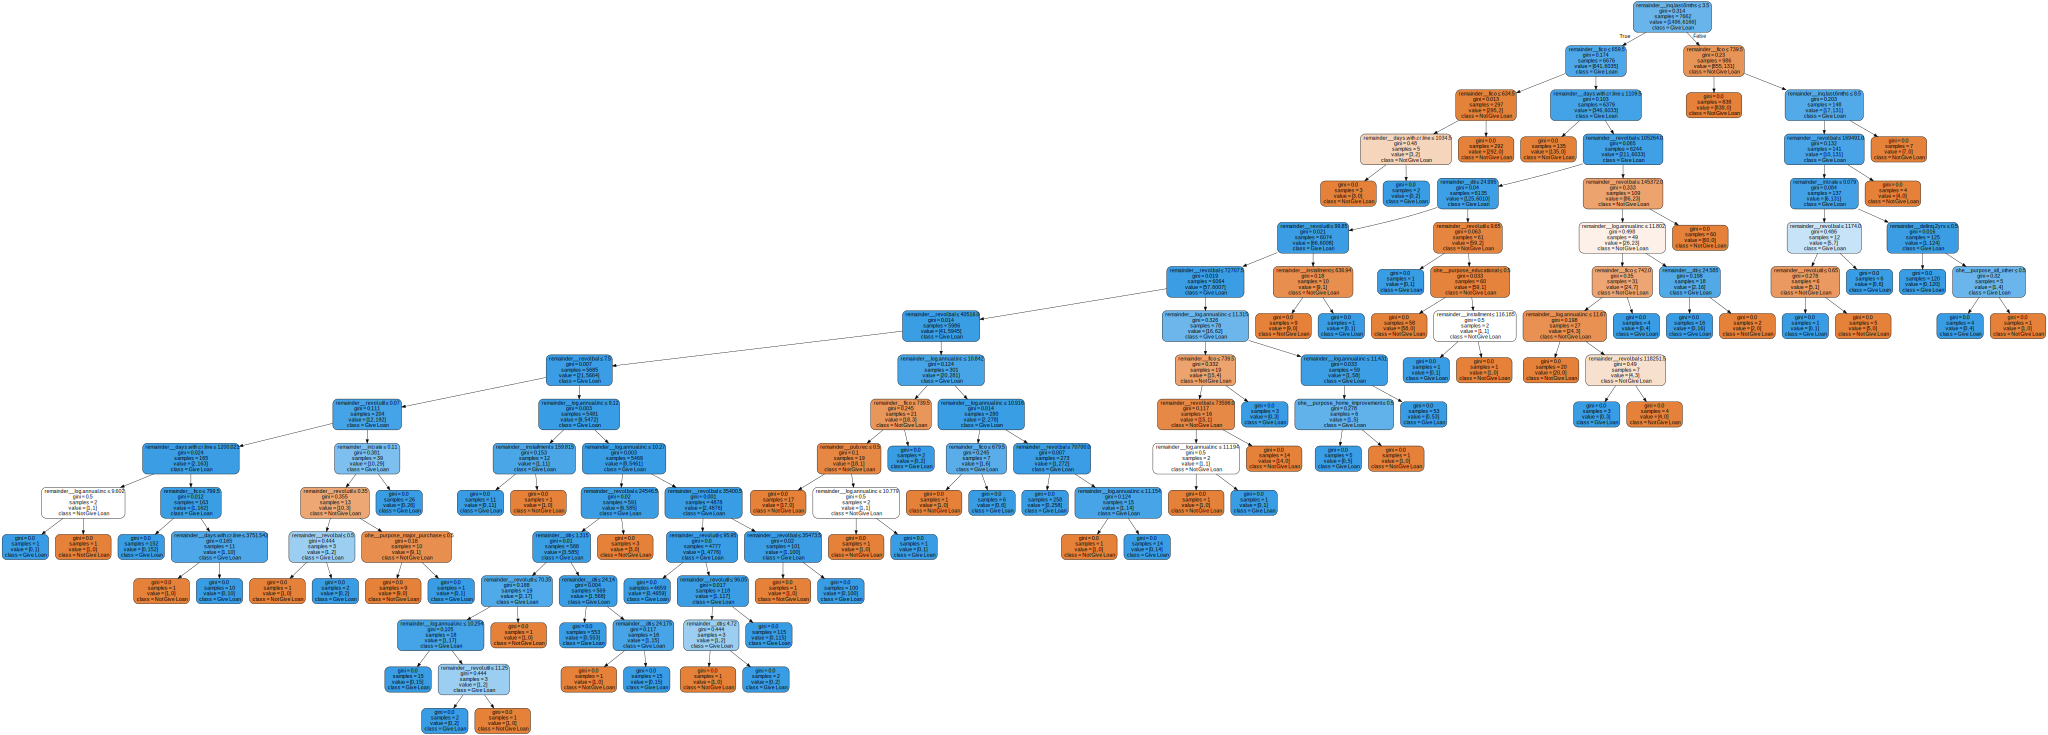

In [ ]:
# Visualisation of the Decision Tree
dt_graph = plot_tree(dt_clf, X_column_transformer.get_feature_names_out())
dt_graph

## Random Forest Classifier

In [ ]:
rf_clf = RandomForestClassifier()
rf_clf = rf_clf.fit(X_train, y_train)

score = rf_clf.score(X_test, y_test)
print(score)

0.9864300626304802


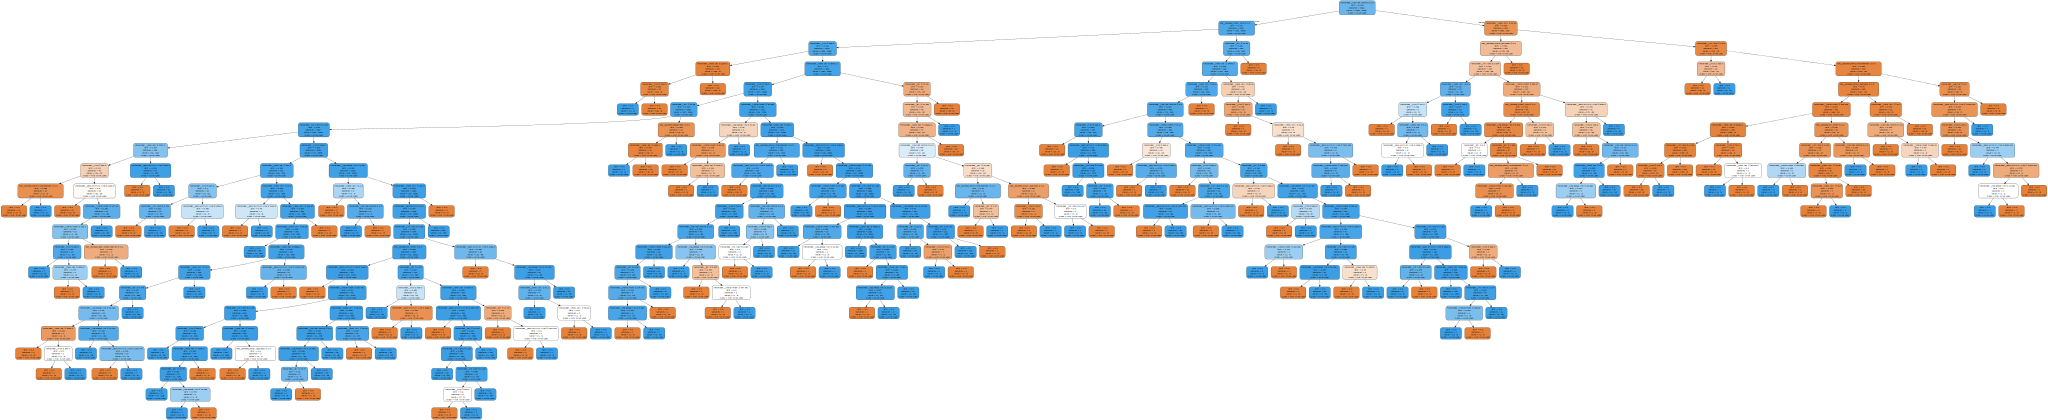

In [ ]:
# Visualisation of the Random Forest
rf_graph = plot_tree(rf_clf[0], X_column_transformer.get_feature_names_out())
rf_graph

## Results analysis and comparison

#### Feature Importance
Feature importance is a great way of
understanding what features are the most
important for the classifier to make a
decision. This is especially useful for
Random Forests, since they are a collection
of Decision Trees.

This will help us understand which features
trees consider the most and how this metrics
differ for a singular DT and a RF.

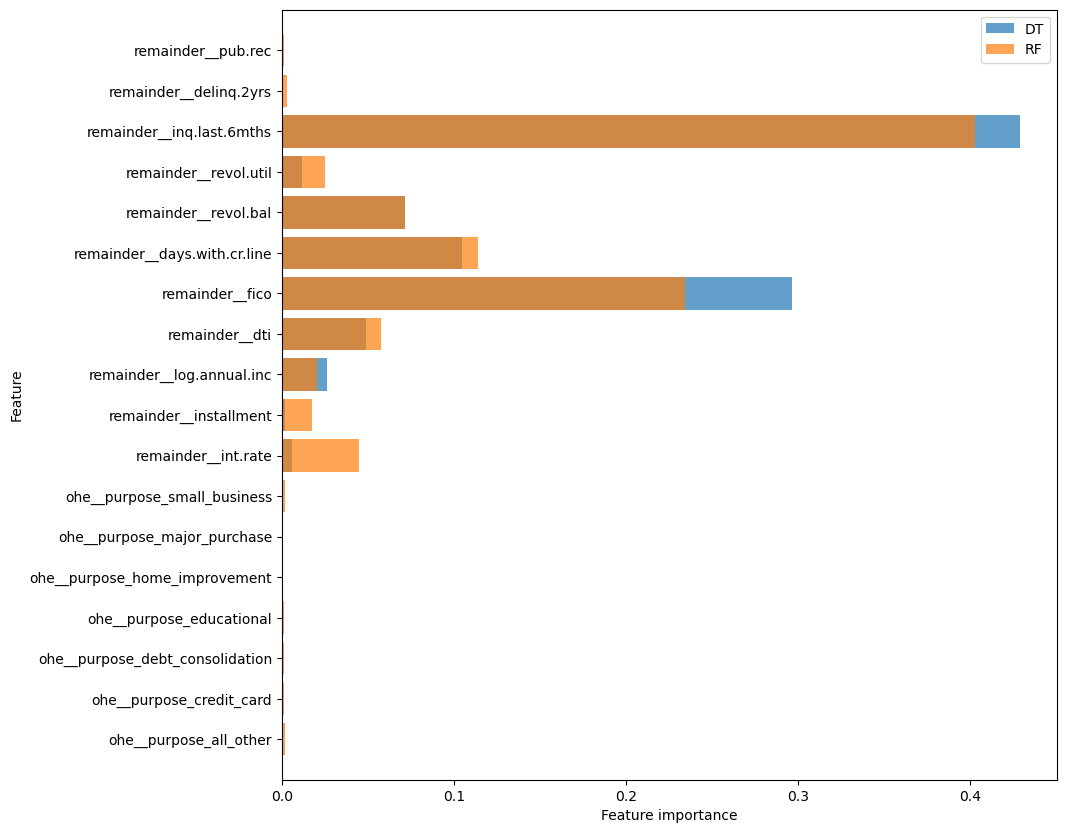

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))

plot_feature_importance(dt_clf, 'DT', X_train.shape[1], X_column_transformer.get_feature_names_out())
plot_feature_importance(rf_clf, 'RF', X_train.shape[1], X_column_transformer.get_feature_names_out())
plt.legend()
plt.show()

As we can see, the singular DT completely ignored the purpose of the loan. Moreover, it has greatly overfitted on the remainder_fico and remainder_inq.last.6mths features.

The RF, on the other hand, has a much more balanced feature importance. It has also ignored the purpose of the loan in general, even though it was considered several times, but it is not biased to these features as much as a singular tree does.

#### Trees Depth
We can also visualize the depth of the trees and compare how a singular DT relates to the trees inside RF

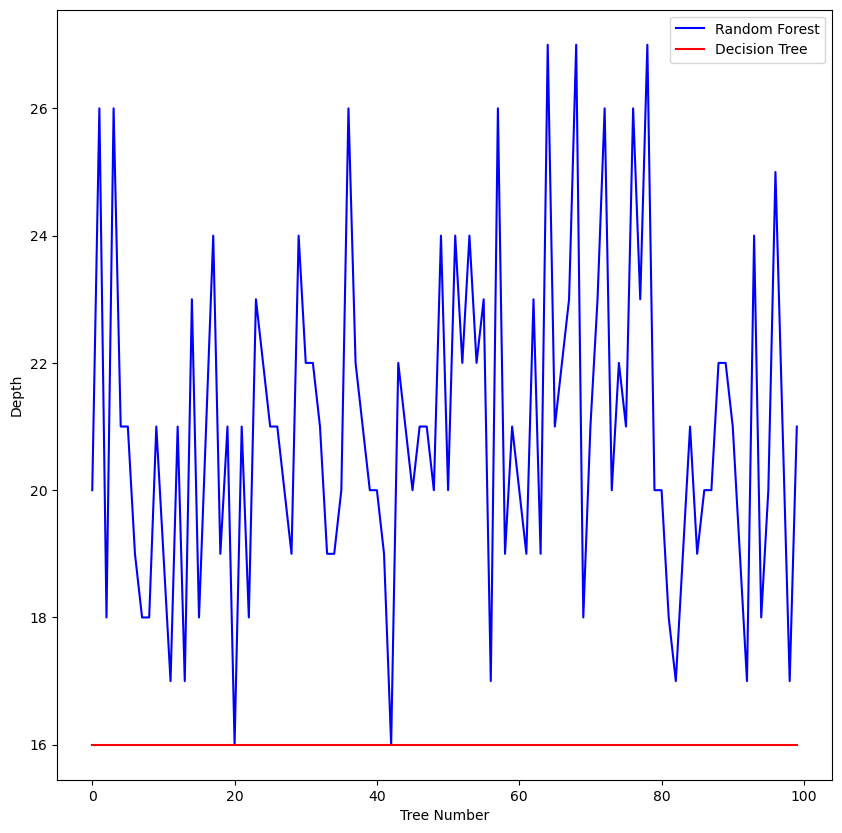

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))

ax.set_xlabel('Tree Number')
ax.set_ylabel('Depth')

xs = range(0, rf_clf.n_estimators)
ys = [rf_clf.estimators_[i].get_depth() for i in xs]
ys1 = [dt_clf.get_depth() for i in xs]

plt.plot(xs, ys, color='blue', label='Random Forest')
plt.plot(xs, ys1, color='red', label='Decision Tree')

plt.legend()
plt.show()

As we can see, almost each tree of the RF has a depth much larger than the singular DT. This is because the RF is a collection of DTs, and each tree is allowed to grow as much as it wants. This is a great way to avoid overfitting, since singular biases towards any of features do not influence the final decision as much as they would in a singular DT.

### Questions
1. How did the DT compare to the RF in performance? Why?
    - *As we can see, the score of RF is slightly worse, even though in general it has very good result. However, previous analysis shows that the RF has a little bit more balanced feature importance, which means that it does not overfit as much as DT does. DT overfitting shows a greater general score, however DT will fail when the data is slightly different then the training data and the RF will be more robust to such changes.*

2. After fine-tuning, how does the max depth in DT compare to RF? Why?
    - *As we can see, the max depth of DT is much smaller than the max depth of trees in RF. (graph is protted above). The reason for that, is that DT as a singular tree can not grow as much as RF without major overfitting. Even though it's depth is not so large, we can clearly see overfitting. The RF, on the other hand, as a collection of DTs, can allow to grow individual trees, since their impact on the decision will be neglected by other trees. As a result, we get a better feature importance balance and a more robust and stable result.*

3. What is ensemble learning? What are its pros and cons?
    - *Ensemble learning is an idea to combine multiple models for prediction. It can solve as classification, as well as regression. Given that we have several models with their hypotheses for predictions for a certain problem. We can combine them in a way that will give us a better result. We can tweak it by trusting some models more, giving them weights. Moreover, we can combine different kinds of models for robustness. However, ensemble learning has a cons as well. It is much more computationally expensive, since we need to train several models. Moreover, it is harder to interpret the results, since we have several models and their own results, which we have to combine.*
4. Briefly explain 2 types of boosting methods and 2 types of bagging methods.
Which of these categories does RF fall under?
    - *Answer*

# Task 4: Domain Gap (15%)

Evaluate your CNN model from task 2 on SVHN data without retraining your model.

In [ ]:
import os

import torchvision
from torch.utils.data import Dataset, DataLoader

In [ ]:
model = CNNModel().to(device)
model.load_state_dict(torch.load('best_cnn_wts.pt'))
model

In [ ]:
img_titles = os.listdir('/content/drive/MyDrive/MLA2/svhn')
img_lables = [title[0:3] for title in img_titles]
images = []
for title in img_titles:
  images.append(torchvision.io.read_image(f'/content/drive/MyDrive/MLA2/svhn/{title}').to(torch.float))

plt.imshow(images[0].permute((1, 2, 0)).to(torch.int))

In [ ]:
class SVHNDataset(Dataset):
  def __init__(self, X, y, transform=None):
    self.X = X
    self.classes = y
    self.transform = transform

  def __len__(self):
    return len(self.X)

  def __getitem__(self, idx):
    resX = self.X[idx]
    resY = idx
    if self.transform is not None:
      resX = self.transform(resX)
    return resX, idx

In [ ]:
predict_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.CenterCrop(84),
    transforms.Normalize((0.5, ), (0.3, )),
    transforms.Grayscale(1),
    transforms.Resize((84, 84)),
    transforms.RandomInvert()
])

predict_dataset = SVHNDataset(images, img_lables, transform=predict_transform)
predict_loader = DataLoader(predict_dataset, batch_size=batch_size, shuffle=False)

dataset_sizes['predict'] = len(predict_dataset)
image_datasets['predict'] = predict_dataset
dataloaders['predict'] = predict_loader

In [ ]:
plt.imshow(torch.squeeze(predict_dataset[0][0]))

In [ ]:
test_model(model, 'predict')

### Questions
1. How did your model perform? Why is it better/worse?

**Answer:**

My model is completely unable to solve the given task.

Prediction result (tensors shown to see one of the examples of confusion):

<div>
<img src="https://drive.google.com/uc?id=1WBuAMmcWCeXn7fPB7xBzGSUTcqJ74Gav" width=500>
</div>

The main reason for this failure 
is that MNIST data is presented in the form of clearly identifiable digits,
always with the same white color on the completely black background. But SVHN
dataset contains images with different colors, different backgrounds, different
sizes and different orientations, even fonts are different. So, the model is not 
able to recognize the digits in the given images.

Even though I have applied different preprocessing techniques to transform
the data in the form which the model is able to recognize, the results are still
very bad. Statistics show that the model is able to recognize at most
10% of digits in the images, which is generally the same as a simple guessing.

Preprocessing example:
<div>
<img src="https://drive.google.com/uc?id=1nrXheUWx_Yyu4-uQXpYJHQqMOfB3PZIj" width=400/>
<img src="https://drive.google.com/uc?id=1_xDG85cPYZWvJ-nM2rimEgdNW6rF5JaC" width=200/>
</div>





2. What is domain gap in the context of ML?
    - *Answer*
3. Suggest two ways through which the problem of domain gap can be tackled.
    - *Answer*

# References

I have used the following resources to learn, understand and implement the assignment.

## General understanding of the topic

- Introduction to Machine Learning Lectures - Innopolis University
- Introduction to Machine Learning Lab Sessions - Innopolis University
- Introduction to Machine Learning Self Practice Sessions - Innopolis University
- [Medium - A Complete Guide to CNN in PyTorch and Keras](https://medium.com/analytics-vidhya/complete-guide-to-build-cnn-in-pytorch-and-keras-abc9ed8b8160)
- [Medium - Multi-class classification in PyTorch](https://towardsdatascience.com/pytorch-tabular-multiclass-classification-9f8211a123ab)
- [Kaggle - Multi-class classification with PyTorch](https://www.kaggle.com/code/schmiddey/multiclass-classification-with-pytorch)
- [PyTorch - NAdam Optimizer](https://pytorch.org/docs/stable/generated/torch.optim.NAdam.html)
- [MachineLearningMastery - Choosing Loss Function](https://machinelearningmastery.com/how-to-choose-loss-functions-when-training-deep-learning-neural-networks/)
- [MachineLearningMastery - Single Digit MNIST Classification](https://machinelearningmastery.com/how-to-develop-a-convolutional-neural-network-from-scratch-for-mnist-handwritten-digit-classification/)
- [LearnOpenCV - Multi-output classification in PyTorch](https://learnopencv.com/multi-label-image-classification-with-pytorch/)
- [LearnOpenCV - Multi-label classification in PyTorch: Image Tagging](https://learnopencv.com/multi-label-image-classification-with-pytorch-image-tagging/)
- [DebuggerCafe - Multi-label classification in PyTorch](https://debuggercafe.com/multi-label-image-classification-with-pytorch-and-deep-learning/)
- [Medium - Multi-label classification in PyTorch](https://towardsdatascience.com/multilabel-classification-with-pytorch-in-5-minutes-a4fa8993cbc7)

## Image Augmentation and Transformation

- [PyTorch - Transforming and Augmenting Images](https://pytorch.org/vision/stable/transforms.html)
- [PyTorch - Illustration of Transforms](https://pytorch.org/vision/stable/auto_examples/plot_transforms.html#sphx-glr-auto-examples-plot-transforms-py)
- [Medium - A Comprehensive Guide to Image Augmentation using Pytorch](https://towardsdatascience.com/a-comprehensive-guide-to-image-augmentation-using-pytorch-fb162f2444be)

## Datasets and Dataloaders

- [PyTorch - Datasets and Dataloaders](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html)
- [PyTorch - Writing Custom Datasets and Dataloaders](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html#writing-custom-datasets-dataloaders-and-transforms)
